In [197]:
%pip install QuantLib

Note: you may need to restart the kernel to use updated packages.


In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import optimize
import QuantLib as ql

In [199]:
spot_rates = pd.read_csv("./data/feds200628.csv")
spot_rates

,Date,BETA0,BETA1,BETA2,BETA3,SVEN1F01,SVEN1F04,SVEN1F09,SVENF01,SVENF02,...,SVENY23,SVENY24,SVENY25,SVENY26,SVENY27,SVENY28,SVENY29,SVENY30,TAU1,TAU2
0,1961/6/14,3.917606e+00,-1.277955,-1.949397,0.000000,3.8067,3.9562,NaN,3.5492,3.8825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339218,-999.990000
1,1961/6/15,3.978498e+00,-1.257404,-2.247617,0.000000,3.8694,4.0183,NaN,3.5997,3.9460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.325775,-999.990000
2,1961/6/16,3.984350e+00,-1.429538,-1.885024,0.000000,3.8634,4.0242,NaN,3.5957,3.9448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.348817,-999.990000
3,1961/6/19,4.004379e+00,-0.723311,-3.310743,0.000000,3.9196,4.0447,NaN,3.6447,3.9842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282087,-999.990000
4,1961/6/20,3.985789e+00,-0.900432,-2.844809,0.000000,3.8732,4.0257,NaN,3.5845,3.9552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.310316,-999.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16393,2024/4/15,1.470000e-12,5.368959,-5.939478,16.230183,4.7443,4.3958,4.8676,4.8564,4.5488,...,4.8312,4.8234,4.8117,4.7963,4.7775,4.7554,4.7304,4.7025,6.242056,13.814110
16394,2024/4/16,3.370010e-04,5.388907,0.248542,13.743298,4.7823,4.4601,4.8756,4.8863,4.5933,...,4.8535,4.8501,4.8436,4.8342,4.8219,4.8070,4.7897,4.7700,3.558715,16.947556
16395,2024/4/17,1.080000e-05,5.361721,-65.418668,73.342855,4.7341,4.3437,4.8063,4.8509,4.5332,...,4.8033,4.7957,4.7838,4.7678,4.7478,4.7243,4.6973,4.6671,9.089550,10.241659
16396,2024/4/18,2.780000e-05,5.370132,1.386560,13.747787,4.7879,4.4261,4.8332,4.8926,4.5949,...,4.8271,4.8237,4.8170,4.8073,4.7948,4.7795,4.7618,4.7416,2.836861,16.727616


In [200]:
column_names = [x for x in spot_rates.columns if "SVENY" in x]
spot_rates['Date'] = pd.to_datetime(spot_rates['Date'])
spot_rates.set_index('Date', inplace=True)
spot_rates = spot_rates[column_names]
spot_rates.loc['2022-09-12']

SVENY01    3.5987
SVENY02    3.6244
SVENY03    3.5876
SVENY04    3.5315
SVENY05    3.4781
SVENY06    3.4370
SVENY07    3.4113
SVENY08    3.4002
SVENY09    3.4018
SVENY10    3.4133
SVENY11    3.4322
SVENY12    3.4562
SVENY13    3.4836
SVENY14    3.5127
SVENY15    3.5425
SVENY16    3.5722
SVENY17    3.6013
SVENY18    3.6293
SVENY19    3.6560
SVENY20    3.6813
SVENY21    3.7051
SVENY22    3.7276
SVENY23    3.7486
SVENY24    3.7682
SVENY25    3.7866
SVENY26    3.8038
SVENY27    3.8198
SVENY28    3.8349
SVENY29    3.8490
SVENY30    3.8622
Name: 2022-09-12 00:00:00, dtype: float64

In [201]:
start_date = pd.to_datetime('2021-09-12')
end_date = pd.to_datetime('2022-09-12')
historic_rates = spot_rates.loc[start_date:end_date]
historic_rates = historic_rates['SVENY01']
historic_rates

Date
2021-09-13    0.0842
2021-09-14    0.0862
2021-09-15    0.0883
2021-09-16    0.0849
2021-09-17    0.0884
               ...  
2022-09-06    3.4580
2022-09-07    3.4496
2022-09-08    3.4879
2022-09-09    3.5742
2022-09-12    3.5987
Name: SVENY01, Length: 261, dtype: float64

In [202]:
T = 30 #total years to simulate
dt = 1/252
#n_steps = int(T/dt)
r0 = historic_rates[-1]
n_scenarios = 1000

In [203]:
def objective(params):
  a, sigma = params
  predicted_rates = [r0]
  for t in range(1, len(historic_rates)):
    dr = (historic_rates[t-1] - a * historic_rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    predicted_rates.append(predicted_rates[-1] + dr)
  predicted_rates = np.array(predicted_rates)
  return np.sum((predicted_rates - historic_rates)**2)

In [204]:
sigma = 0.01
a = 0.1
timestep = 60
length = 30
#forward_rate = 0.05
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count = ql.Thirty360(ql.Thirty360.USA)
todays_date = ql.Date(12, 9, 2022)
ql.Settings.instance().evaluationDate = todays_date

In [205]:
rates = [3.5987, 3.6244, 3.5876, 3.5315, 3.4781, 3.4370, 3.4113, 3.4002, 3.4018, 3.4133, 3.4322, 3.4562, 3.4836, 3.5127, 3.5425, 3.5722, 3.6013, 3.6293, 3.6560, 3.6813, 3.7051, 3.7276, 3.7486, 3.7682, 3.7866, 3.8038, 3.8198, 3.8349, 3.8490, 3.8622, 3.8700]
tenors = [i for i in range(1, 32)]

In [206]:
spot_dates = [calendar.advance(todays_date, ql.Period(tenor, ql.Years)) for tenor in tenors]
spot_rates = [rate / 100.0 for rate in rates]
spot_dates

[Date(12,9,2023),
 Date(12,9,2024),
 Date(12,9,2025),
 Date(14,9,2026),
 Date(13,9,2027),
 Date(12,9,2028),
 Date(12,9,2029),
 Date(12,9,2030),
 Date(12,9,2031),
 Date(13,9,2032),
 Date(12,9,2033),
 Date(12,9,2034),
 Date(12,9,2035),
 Date(12,9,2036),
 Date(14,9,2037),
 Date(13,9,2038),
 Date(12,9,2039),
 Date(12,9,2040),
 Date(12,9,2041),
 Date(12,9,2042),
 Date(14,9,2043),
 Date(12,9,2044),
 Date(12,9,2045),
 Date(12,9,2046),
 Date(12,9,2047),
 Date(14,9,2048),
 Date(13,9,2049),
 Date(12,9,2050),
 Date(12,9,2051),
 Date(12,9,2052),
 Date(12,9,2053)]

In [207]:
curve = ql.ZeroCurve(spot_dates, spot_rates, day_count, calendar, ql.Linear(), ql.Compounded, ql.Annual)
spot_curve_handle = ql.YieldTermStructureHandle(curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [208]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    #print("start")
    for i in range(num_paths):
        sample_path = seq.next()
        #print(sample_path)
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        #print(time)
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

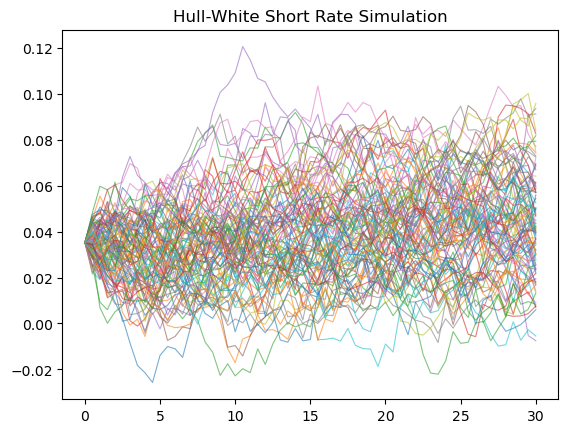

In [209]:
num_paths = 100
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

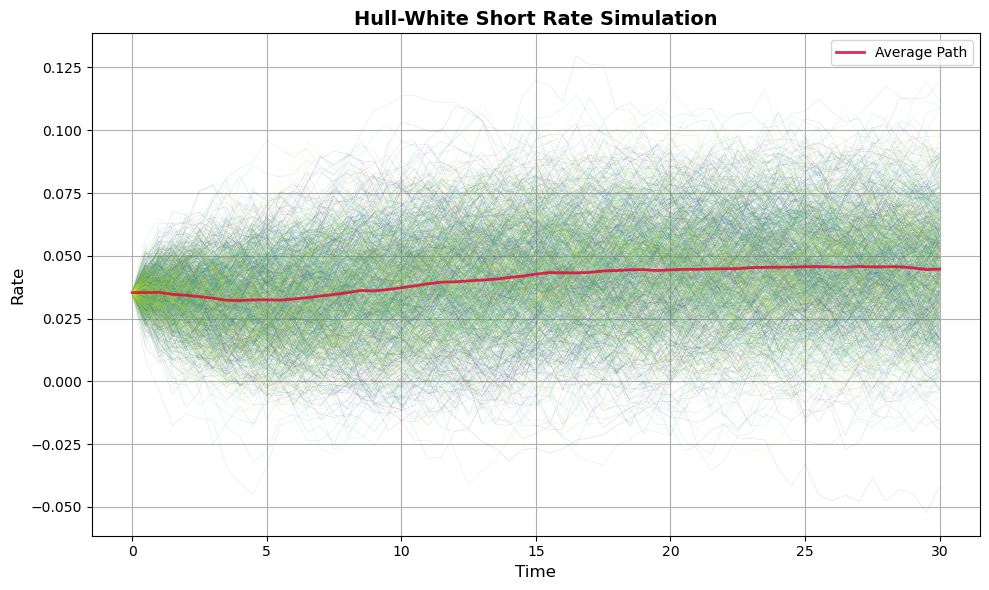

In [281]:
num_paths = 1000
time, paths = generate_paths(num_paths, timestep)
from matplotlib.cm import viridis
average_path = np.mean(paths, axis=0)

# Generate a color map for the paths
colors = viridis(np.linspace(0, 1, num_paths))

plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.2, alpha=0.3, color=colors[i])

# Plot the average path with a thicker line
plt.plot(time, average_path, lw=2, alpha=0.9, color='crimson', label='Average Path')

plt.title("Hull-White Short Rate Simulation", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Rate", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

In [210]:
yield_curves = paths[:, 1:]
yield_curves.shape

(100, 60)

In [211]:
cash_flows = np.loadtxt("./data/C.csv")
cash_flows

array([[2.625, 2.625, 2.625, ..., 0.   , 0.   , 0.   ],
       [1.25 , 1.25 , 1.25 , ..., 0.   , 0.   , 0.   ],
       [0.625, 0.625, 0.625, ..., 0.   , 0.   , 0.   ],
       ...,
       [1.45 , 0.   , 1.45 , ..., 0.   , 0.   , 0.   ],
       [0.   , 2.35 , 0.   , ..., 0.   , 0.   , 0.   ],
       [2.9  , 0.   , 2.9  , ..., 0.   , 0.   , 0.   ]])

In [212]:

bond_prices = np.zeros((20, 100))

for bond_index in range(20):
    bond_cash_flows = cash_flows[bond_index]

    for curve_index in range(100):
        discount_rates = yield_curves[curve_index]

        discounted_cash_flows = bond_cash_flows / (1 + discount_rates/2) ** np.arange(1, 61)
        bond_price = np.sum(discounted_cash_flows)

        bond_prices[bond_index, curve_index] = bond_price
bond_prices

array([[ 98.64936855, 111.58475237, 100.50266365, ..., 105.43818003,
        101.27347988, 107.88367197],
       [ 91.33210023, 107.80872671,  92.87347208, ..., 103.51393629,
         98.76266076, 102.55523203],
       [ 89.73037051, 107.21827292,  81.49347053, ..., 100.49962772,
         93.84524627,  97.42962707],
       ...,
       [ 91.35963722, 109.00052203,  83.12550916, ..., 102.26246979,
         95.52029344,  99.13360143],
       [ 94.87932747, 132.24960805,  61.71947125, ..., 112.75527649,
         93.44160116, 103.38467398],
       [ 77.76748234,  98.37813838,  54.06944571, ...,  71.54472132,
         70.32737415, 118.36581408]])

In [213]:
bond_prices.shape

(20, 100)

In [214]:
nominal_weights = np.loadtxt("./data/target_weights.csv")
nominal_weights.shape

(20,)

In [215]:
portfolio_values = np.zeros(100)

for curve_index in range(100):
    portfolio_value = np.sum(bond_prices[:, curve_index] * nominal_weights)
    portfolio_values[curve_index] = portfolio_value
min(portfolio_values)

83.25616102779027

In [216]:
portfolio_values.shape

(100,)

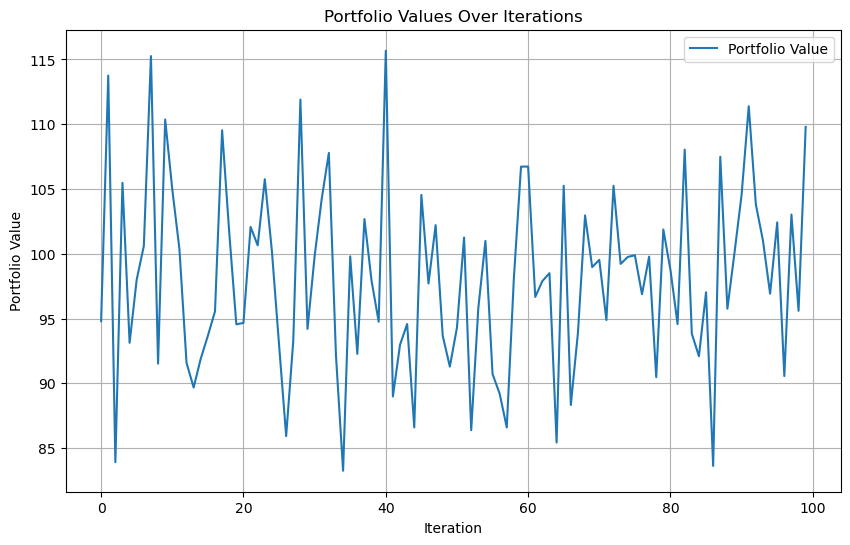

In [217]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.title('Portfolio Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [218]:
cash_flows

array([[2.625, 2.625, 2.625, ..., 0.   , 0.   , 0.   ],
       [1.25 , 1.25 , 1.25 , ..., 0.   , 0.   , 0.   ],
       [0.625, 0.625, 0.625, ..., 0.   , 0.   , 0.   ],
       ...,
       [1.45 , 0.   , 1.45 , ..., 0.   , 0.   , 0.   ],
       [0.   , 2.35 , 0.   , ..., 0.   , 0.   , 0.   ],
       [2.9  , 0.   , 2.9  , ..., 0.   , 0.   , 0.   ]])

In [331]:
def calculate_portfolio_values(yield_curves, cash_flows, weights):
    number_of_curves = yield_curves.shape[0]
    number_of_periods = cash_flows.shape[1]
    portfolio_values_over_time = np.zeros((number_of_periods, number_of_curves))
    
    for curve_index in range(number_of_curves):
        for time_period in range(number_of_periods):
            # Select the cash flows from the current period to the end
            relevant_cash_flows = cash_flows[:, time_period:]
                        
            # Compute discount factors for continuous compounding
            discount_factors = np.exp(
                -yield_curves[curve_index, time_period:] * 
                np.arange(0.5, (number_of_periods-time_period+1) * 0.5, 0.5)
            ).reshape(-1, 1)
            
            # # Ensure that the cash flows and discount factors have compatible shapes
            # if discount_factors.shape[0] != relevant_cash_flows.shape[1]:
            #     # Adjust the shape of discount factors if necessary
            #     discount_factors = discount_factors[:relevant_cash_flows.shape[1], :]
            
            # Calculate the present value of the cash flows
            bond_values = np.sum(relevant_cash_flows * discount_factors.T, axis=1)
            # if time_period==20:
            #     print("relavent cash flows:", relevant_cash_flows)

            active_bonds = (relevant_cash_flows.sum(axis=1) != 0)
            
            # Adjust weights for bonds with cash flows
            adjusted_weights = np.where(active_bonds, weights, 0)
            #adjusted_weights /= adjusted_weights.sum() if adjusted_weights.sum() != 0 else 1
            # if time_period==20:
            #     print("adjusted weights:", adjusted_weights)
            
            #Calculate the portfolio value
            portfolio_value = np.dot(bond_values, adjusted_weights)
            
            # Store the portfolio value for the current time period and yield curve
            portfolio_values_over_time[time_period, curve_index] = portfolio_value


            
            # # Calculate the portfolio value
            # portfolio_value = np.dot(bond_values, weights)
            
            # # Store the portfolio value for the current time period and yield curve
            # portfolio_values_over_time[time_period, curve_index] = portfolio_value
    
    return portfolio_values_over_time

In [238]:
pv_nominal_over_time = calculate_portfolio_values(yield_curves, cash_flows, nominal_weights)
pv_nominal_over_time.shape

adjusted weights: [0.         0.         0.         0.02855289 0.03950715 0.
 0.         0.         0.01431773 0.01286434 0.         0.
 0.         0.04883286 0.04361683 0.         0.         0.
 0.02436576 0.0285041 ]
adjusted weights: [0.         0.         0.         0.02855289 0.03950715 0.
 0.         0.         0.01431773 0.01286434 0.         0.
 0.         0.04883286 0.04361683 0.         0.         0.
 0.02436576 0.0285041 ]
adjusted weights: [0.         0.         0.         0.02855289 0.03950715 0.
 0.         0.         0.01431773 0.01286434 0.         0.
 0.         0.04883286 0.04361683 0.         0.         0.
 0.02436576 0.0285041 ]
adjusted weights: [0.         0.         0.         0.02855289 0.03950715 0.
 0.         0.         0.01431773 0.01286434 0.         0.
 0.         0.04883286 0.04361683 0.         0.         0.
 0.02436576 0.0285041 ]
adjusted weights: [0.         0.         0.         0.02855289 0.03950715 0.
 0.         0.         0.01431773 0.01286434 0.

(60, 100)

In [245]:
def plot_portfolio_values_over_time(portfolio_values_over_time, weights):
    """
    Plots the portfolio values over time for a number of yield curve scenarios,
    but only for the first 20 time periods.
    
    :param portfolio_values_over_time: A 2D array with portfolio values over time.
                                       Rows are time periods, columns are different scenarios.
    :param weights: Weights of different bonds in the portfolio.
    """
    plt.figure(figsize=(14, 7))
    num_periods_to_plot = 20  # Limiting the number of periods to plot to the first 20

    # Ensure not to exceed the actual number of periods in the data
    max_periods = min(num_periods_to_plot, portfolio_values_over_time.shape[0])

    for curve_index in range(portfolio_values_over_time.shape[1]):
        plt.plot(range(1, max_periods + 1), portfolio_values_over_time[:max_periods, curve_index], alpha=0.2)

    plt.title('Bond Portfolio Value Over Time for {} Yield Curve Scenarios for {}'.format(portfolio_values_over_time.shape[1], weights))
    plt.xlabel('Time Periods (Half-Yearly)')
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    #plt.legend(['Scenario ' + str(i+1) for i in range(portfolio_values_over_time.shape[1])], loc='upper left')
    plt.show()

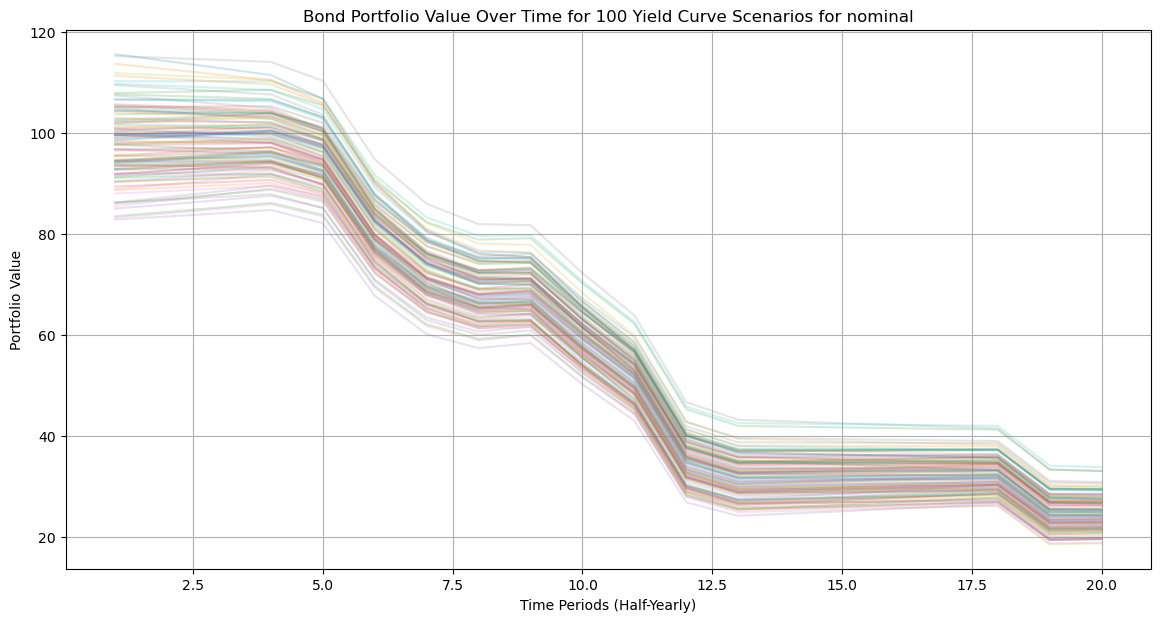

In [246]:
plot_portfolio_values_over_time(pv_nominal_over_time, 'nominal')

In [228]:
modest = pd.read_csv("./data/modest.csv")


def convert_string_to_list(string):
    string = string.strip('[]').replace('\n', '')
    str_list = [x.strip() for x in string.split(' ') if x.strip() != '']
    return [float(i) for i in str_list if i]

# 应用这个函数到每一行
modest['weights'] = modest['weights'].apply(convert_string_to_list)

# 展开列表到新的dataframe
weights_df = pd.DataFrame(modest['weights'].tolist())

In [329]:
extreme = pd.read_csv("./data/extreme.csv")
extreme["weights"] = extreme['weights'].apply(convert_string_to_list)
# weights_ex_df = pd.DataFrame(extreme["weights"].to_list)

float

adjusted weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.92624069e-11
 5.00168633e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.14194637e-11 5.43622396e-11 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.23239845e-11 5.08712774e-11 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.10928673e-10 4.70459581e-11]
adjusted weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.92624069e-11
 5.00168633e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.14194637e-11 5.43622396e-11 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.23239845e-11 5.08712774e-11 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.10928673e-10 4.70459581e-11]
adjusted weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.92624069e-11
 5.00168633e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.14194637e-11 5.43622396e-11 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.23239845e-11 5.08712774e-11 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.10928673e-10 4.70459581e-11]
adjusted weights: [0.0000000

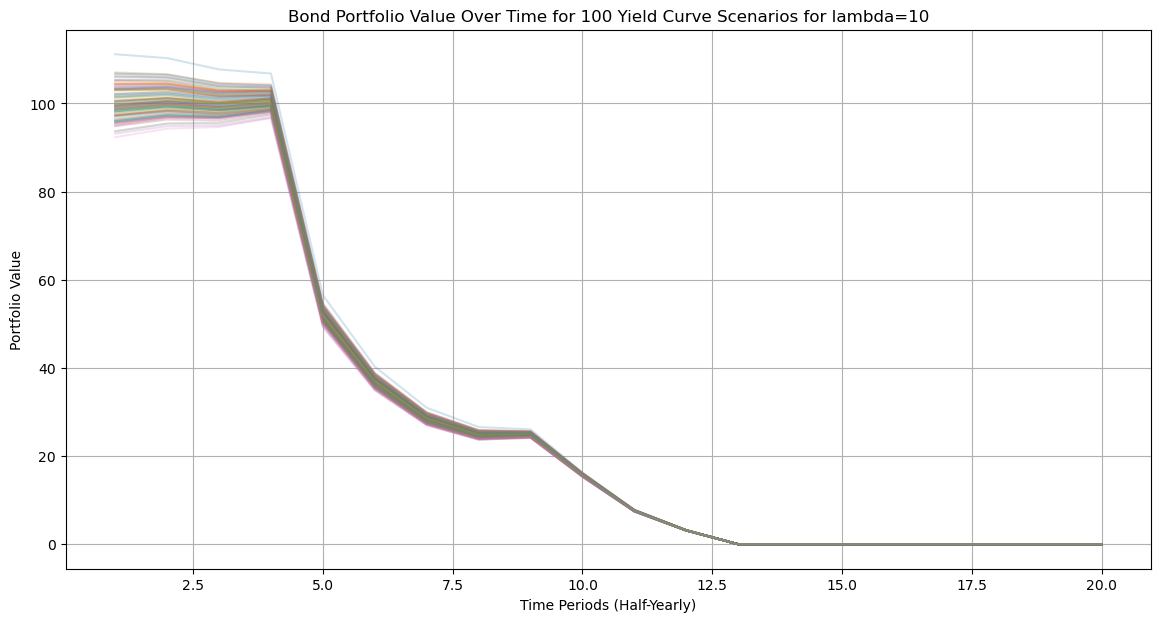

In [257]:
pv_modest1_overtime = calculate_portfolio_values(yield_curves, cash_flows, weights_df.iloc[10])
plot_portfolio_values_over_time(pv_modest1_overtime, "lambda=10")


adjusted weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.84954193e-09
 2.50254120e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.06569629e-09 2.81334957e-09 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.97675823e-09 2.39644554e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.02585837e-09 2.25704301e-09]
adjusted weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.84954193e-09
 2.50254120e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.06569629e-09 2.81334957e-09 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.97675823e-09 2.39644554e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.02585837e-09 2.25704301e-09]
adjusted weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.84954193e-09
 2.50254120e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.06569629e-09 2.81334957e-09 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.97675823e-09 2.39644554e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.02585837e-09 2.25704301e-09]
adjusted weights: [0.0000000

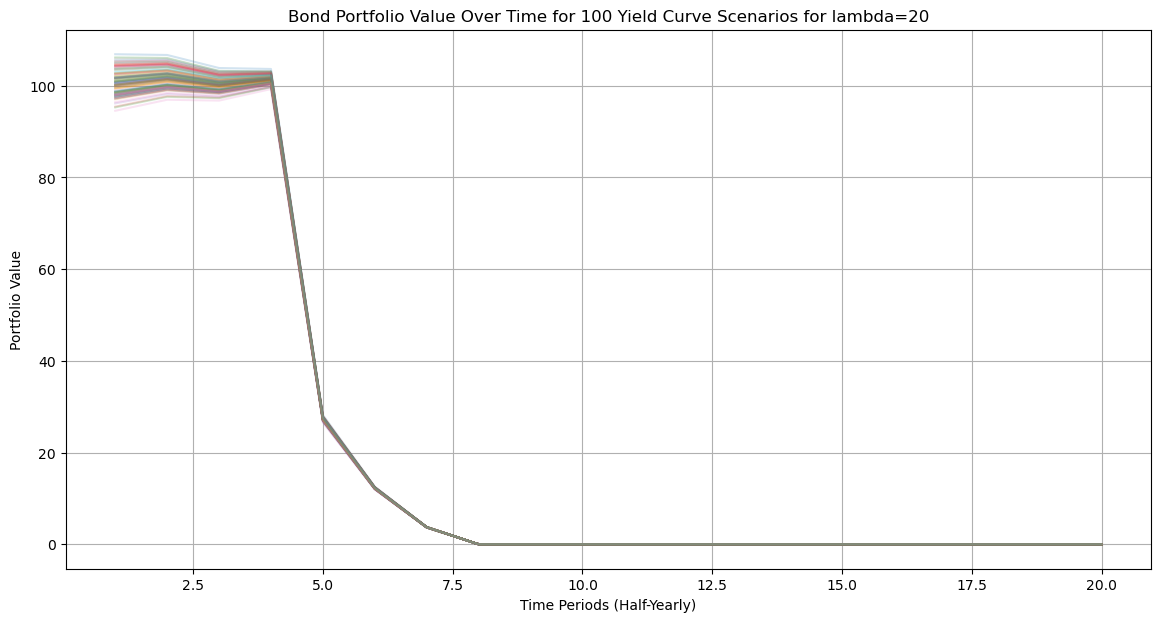

In [258]:
pv_modest2_overtime = calculate_portfolio_values(yield_curves, cash_flows, weights_df.iloc[20])
plot_portfolio_values_over_time(pv_modest2_overtime, "lambda=20")

In [236]:
cash_flows[0:12]

array([[2.62500e+00, 2.62500e+00, 2.62500e+00, 2.62500e+00, 1.02625e+02,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [1.25000e+00, 1.25000e+00, 1.25000e+00, 1.25000e+00, 1.25000e+00,
        1.25000e+00, 1.25000e+00, 1.25000e+00, 1.0

In [342]:
def plot_multiple_portfolio_values(portfolio_values_list):
    plt.figure(figsize=(14, 7))

    # Determine the minimum time periods to plot based on all sets
    min_periods = min(pv_set[0].shape[0] for pv_set in portfolio_values_list)
    print(min_periods)
    num_periods_to_plot = min(4, min_periods)
    
    # Define colors for each set, you can add more colors if you have more sets
    colors = ['blue', 'red', 'green', 'yellow', 'orange']
    legend_handles = []  # List to hold the legend handles

    

    for index, (portfolio_values, label) in enumerate(portfolio_values_list):
        #Get max and min for the shade
        max_curve = np.max(portfolio_values[:num_periods_to_plot, :], axis=1)
        min_curve = np.min(portfolio_values[:num_periods_to_plot, :], axis=1)

        
        # Fill between the max and min curves
        fill = plt.fill_between(range(1, num_periods_to_plot + 1, 1), min_curve, max_curve, 
                         color=colors[index], alpha=0.1)
        legend_handles.append(fill)  # Add the fill to legend handles

        # Plot the max and min with dashed lines
        plt.plot(range(1, num_periods_to_plot + 1, 1), max_curve, 'k--', alpha=0.75)
        plt.plot(range(1, num_periods_to_plot + 1, 1), min_curve, 'k--', alpha=0.75)
            
    plt.title(f'Bond Portfolio Value Over Time for Multiple Yield Curve Scenarios')
    plt.xlabel('Time Periods (Half-Yearly)')
    plt.xticks(np.arange(1, num_periods_to_plot + 1, 1))
    plt.ylabel('Portfolio Value')
    plt.grid(True)
    
    # Create legend labels based on the provided labels
    legend_labels = [label for _, label in portfolio_values_list]
    plt.legend(legend_handles, legend_labels, loc='upper right')  # Update legend to use handles
    plt.show()


60


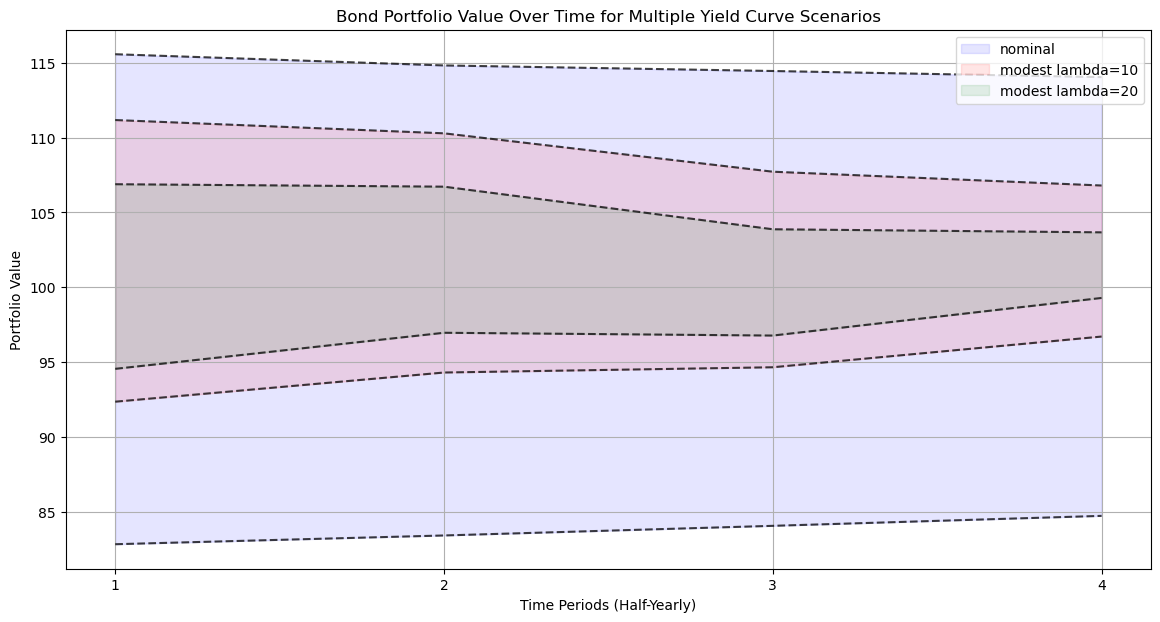

In [343]:
pv_lists = [
    (pv_nominal_over_time, "nominal"),
    (pv_modest1_overtime, "modest lambda=10"),
    (pv_modest2_overtime, "modest lambda=20")
]
plot_multiple_portfolio_values(pv_lists)

In [335]:
pv_extreme1_over_time = calculate_portfolio_values(yield_curves, cash_flows, extreme["weights"].iloc[10])
pv_extreme2_over_time = calculate_portfolio_values(yield_curves, cash_flows, extreme["weights"].iloc[20])

60


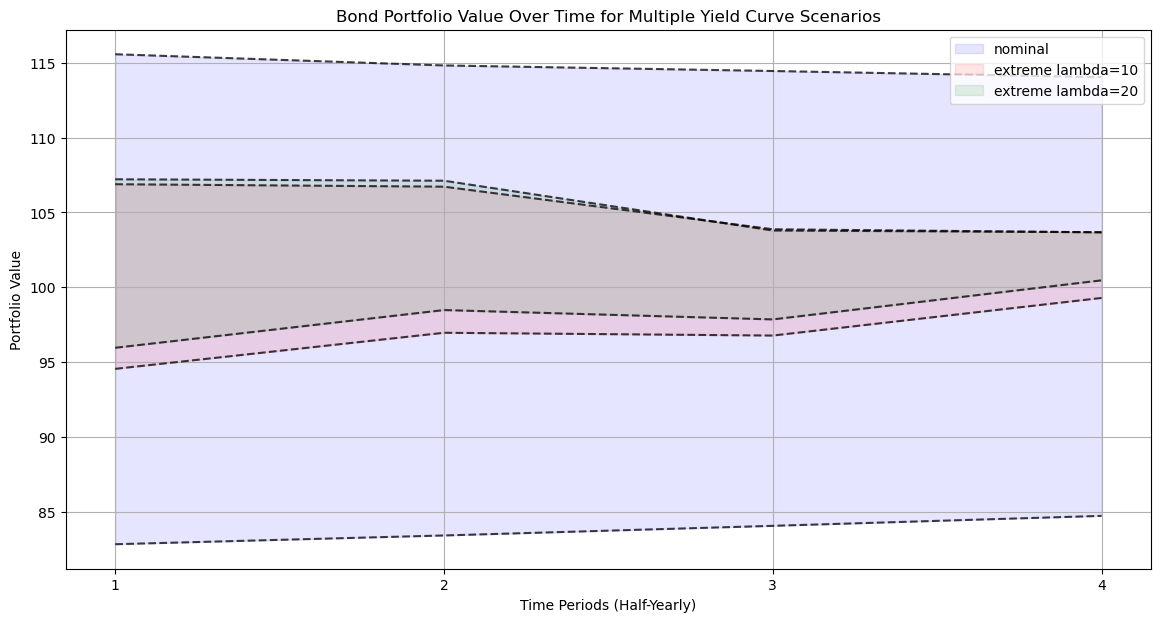

In [345]:
pv_extreme_lists = [
    (pv_nominal_over_time, "nominal"),
    (pv_extreme1_over_time, "extreme lambda=10"),
    (pv_extreme2_over_time, "extreme lambda=20"),
]
plot_multiple_portfolio_values(pv_extreme_lists)